# Overview of this notebook

Using the merged clean dataset, we joined our merged data with spatial data in order to isolate accidents that occurred within and without Senior Pedestrian Focus Areas. With that joined data, we could the gather some initial descriptive statistics.

### Libraries

In [1]:
import pandas as pd
import geopandas as gpd
import shapely
from fiona.crs import from_epsg
import matplotlib.pylab as plt
import numpy as np
pd.set_option('display.max_columns', 500)

### Load data

In [2]:
merged_data = pd.read_csv('../data/cleanData/mergedClean.csv')
merged_data.head()

ST_CASE_YEAR  SENIOR  S_PED  S_NOT_PED  S_PED_DEAD  S_SURVIVED  S_DEAD  \
0  360094_2001     1.0    1.0        0.0         1.0         0.0     1.0   
1  360118_2001     3.0    1.0        2.0         1.0         0.0     3.0   
2  360150_2001     2.0    2.0        0.0         2.0         0.0     2.0   
3  360168_2001     1.0    1.0        0.0         1.0         0.0     1.0   
4  360169_2001     1.0    1.0        0.0         1.0         0.0     1.0   

   S_DRINKING+  S_DRINKING-  S_MALE  S_FEMALE  S_DRUG+  S_DRUG-  S_DEAD_AFTER  \
0          0.0          1.0     1.0       0.0      0.0      1.0           1.0   
1          0.0          1.0     3.0       0.0      0.0      1.0           2.0   
2          0.0          2.0     1.0       1.0      0.0      2.0           2.0   
3          0.0          1.0     0.0       1.0      0.0      1.0           1.0   
4          0.0          1.0     1.0       0.0      0.0      1.0           1.0   

   S_DEAD_SCENE  S_DEAD_ROUTE  ALIGNMNT  ARR_HOUR  ARR_MIN  CF1  CF2  CF3  \
0           0.0           0.0       1.0      99.0     99.0  0.0  0.0  0.0   
1           1.0           0.0       1.0      99.0     99.0  0.0  0.0  0.0   
2           0.0           0.0       1.0      99.0     99.0  0.0  0.0  0.0   
3           0.0           0.0       1.0      99.0     99.0  0.0  0.0  0.0   
4           0.0           0.0       1.0      99.0     99.0  0.0  0.0  0.0   

     CITY  COUNTY  C_M_ZONE   DAY  DAY_WEEK  DRUNK_DR  FATALS  FUNC_SYS  \
0  4170.0    47.0       0.0  25.0       5.0       0.0     1.0       NaN   
1  4170.0    61.0       0.0  18.0       5.0       1.0     1.0       NaN   
2  4170.0    81.0       0.0  23.0       3.0       0.0     2.0       NaN   
3  4170.0    61.0       0.0  31.0       4.0       0.0     1.0       NaN   
4  4170.0     5.0       0.0  20.0       3.0       0.0     1.0       NaN   

   HARM_EV  HIT_RUN  HOSP_HR  HOSP_MN  HOUR   LATITUDE  LGT_COND   LONGITUD  \
0      8.0      0.0     99.0     99.0  18.0        NaN       5.0        NaN   
1      8.0      0.0     99.0     99.0  16.0  40.832786       5.0 -73.945856   
2      8.0      0.0     99.0     99.0  13.0  40.681522       1.0 -73.817803   
3      8.0      0.0     99.0     99.0  17.0  40.771333       3.0 -73.983200   
4      8.0      0.0     99.0     99.0  12.0        NaN       1.0        NaN   

   MAN_COLL  MILEPT  MINUTE  MONTH  NHS  NOT_HOUR  NOT_MIN  NO_LANES  \
0       0.0     0.0     5.0    1.0  0.0      99.0     99.0       4.0   
1       0.0     0.0    32.0    1.0  0.0      99.0     99.0       4.0   
2       0.0     0.0    30.0    1.0  0.0      99.0     99.0       2.0   
3       0.0     0.0    52.0    1.0  0.0      99.0     99.0       4.0   
4       0.0     0.0    10.0    3.0  0.0      99.0     99.0       2.0   

   PAVE_TYP  PEDS  PERMVIT  PERNOTMVIT  PERSONS  PROFILE  PVH_INVL  RAIL  \
0       2.0   1.0      NaN         NaN      3.0      1.0       NaN     0   
1       2.0   1.0      NaN         NaN      4.0      2.0       NaN     0   
2       2.0   2.0      NaN         NaN      3.0      1.0       NaN     0   
3       2.0   1.0      NaN         NaN      3.0      1.0       NaN     0   
4       2.0   1.0      NaN         NaN      3.0      1.0       NaN     0   

   RD_OWNER  RELJCT1  RELJCT2  REL_JUNC  REL_ROAD  ROAD_FNC  ROUTE  RUR_URB  \
0       NaN      NaN      NaN       2.0       1.0      13.0    6.0      NaN   
1       NaN      NaN      NaN       2.0       1.0      13.0    6.0      NaN   
2       NaN      NaN      NaN       2.0       1.0       6.0    6.0      NaN   
3       NaN      NaN      NaN       2.0       1.0      13.0    6.0      NaN   
4       NaN      NaN      NaN       1.0       1.0      13.0    6.0      NaN   

   SCH_BUS  SP_JUR  SP_LIMIT  STATE  ST_CASE  SUR_COND  TRAF_FLO  TRA_CONT  \
0      0.0     0.0      30.0   36.0   360094       1.0       1.0       3.0   
1      0.0     0.0      99.0   36.0   360118       2.0       1.0       3.0   
2      0.0     0.0      99.0   36.0   360150       1.0       1.0      

In [3]:
merged_data.columns

Index(['ST_CASE_YEAR', 'SENIOR', 'S_PED', 'S_NOT_PED', 'S_PED_DEAD',
       'S_SURVIVED', 'S_DEAD', 'S_DRINKING+', 'S_DRINKING-', 'S_MALE',
       'S_FEMALE', 'S_DRUG+', 'S_DRUG-', 'S_DEAD_AFTER', 'S_DEAD_SCENE',
       'S_DEAD_ROUTE', 'ALIGNMNT', 'ARR_HOUR', 'ARR_MIN', 'CF1', 'CF2', 'CF3',
       'CITY', 'COUNTY', 'C_M_ZONE', 'DAY', 'DAY_WEEK', 'DRUNK_DR', 'FATALS',
       'FUNC_SYS', 'HARM_EV', 'HIT_RUN', 'HOSP_HR', 'HOSP_MN', 'HOUR',
       'LATITUDE', 'LGT_COND', 'LONGITUD', 'MAN_COLL', 'MILEPT', 'MINUTE',
       'MONTH', 'NHS', 'NOT_HOUR', 'NOT_MIN', 'NO_LANES', 'PAVE_TYP', 'PEDS',
       'PERMVIT', 'PERNOTMVIT', 'PERSONS', 'PROFILE', 'PVH_INVL', 'RAIL',
       'RD_OWNER', 'RELJCT1', 'RELJCT2', 'REL_JUNC', 'REL_ROAD', 'ROAD_FNC',
       'ROUTE', 'RUR_URB', 'SCH_BUS', 'SP_JUR', 'SP_LIMIT', 'STATE', 'ST_CASE',
       'SUR_COND', 'TRAF_FLO', 'TRA_CONT', 'TWAY_ID', 'TWAY_ID2', 'TYP_INT',
       'T_CONT_F', 'VE_FORMS', 'VE_TOTAL', 'WEATHER', 'WEATHER1', 'WEATHER2',
       'WRK_ZONE', '

In [4]:
merged_data[merged_data['S_PED']>0]['S_DEAD'].count()

936

In [5]:
merged_data.dropna(subset=['LONGITUD', 'LATITUDE'], inplace=True)

In [6]:
merged_data.shape

(919, 81)

Note that we lost 49 rows after dropping missing longitude and latitude information (936 - 919 = 17).

## Spatial join with NYC PUMAs

Next, we joined our NYC data with PUMA data for visualization purposes.

In [7]:
# Prep merged df for spatial join
merged_data['lonlat'] = list(zip(merged_data.LONGITUD, merged_data.LATITUDE))
merged_data['geometry'] = merged_data[['lonlat']].applymap(lambda x:shapely.geometry.Point(x))
merged_data_gdf = gpd.GeoDataFrame(merged_data)

In [8]:
# Set epsg for spatial join
merged_data_gdf.crs = from_epsg(4326)
merged_data_gdf.to_crs(epsg=4326, inplace = True)

In [10]:
# Get PUMA shapefile for spatial join with NYC df
files = !ls ../data/puma
pumashp = files[2]
loc = '../data/puma/' + pumashp
pumashp = gpd.GeoDataFrame.from_file(loc)

In [11]:
# Set epsg for spatial join
pumashp.crs = from_epsg(4326)
pumashp.to_crs(epsg=4326, inplace = True)

In [12]:
# Spatial join to only keep those accidents that occurred in NYC based on the NYC's PUMA shapefile
merged_sjoin = gpd.tools.sjoin(merged_data_gdf,pumashp)

In [13]:
print("Number of rows lost from merged gdf after spatial join: " + str(merged_data_gdf.LATITUDE.count() - \
                                                                 merged_sjoin.LATITUDE.count()))

Number of rows lost from merged gdf after spatial join: 12


In [14]:
merged_sjoin.head()

ST_CASE_YEAR  SENIOR  S_PED  S_NOT_PED  S_PED_DEAD  S_SURVIVED  S_DEAD  \
1    360118_2001     3.0    1.0        2.0         1.0         0.0     3.0   
46   361325_2001     1.0    1.0        0.0         1.0         0.0     1.0   
95   360966_2002     1.0    1.0        0.0         1.0         0.0     1.0   
120  361302_2002     2.0    1.0        1.0         1.0         0.0     2.0   
144  360270_2003     1.0    1.0        0.0         1.0         0.0     1.0   

     S_DRINKING+  S_DRINKING-  S_MALE  S_FEMALE  S_DRUG+  S_DRUG-  \
1            0.0          1.0     3.0       0.0      0.0      1.0   
46           0.0          1.0     1.0       0.0      0.0      1.0   
95           0.0          1.0     1.0       0.0      0.0      1.0   
120          0.0          2.0     2.0       0.0      0.0      2.0   
144          0.0          1.0     0.0       1.0      0.0      1.0   

     S_DEAD_AFTER  S_DEAD_SCENE  S_DEAD_ROUTE  ALIGNMNT  ARR_HOUR  ARR_MIN  \
1             2.0           1.0           0.0       1.0      99.0     99.0   
46            1.0           0.0           0.0       1.0      99.0     99.0   
95            1.0           0.0           0.0       1.0      99.0     99.0   
120           1.0           0.0           0.0       1.0      99.0     99.0   
144           1.0           0.0           0.0       1.0      99.0     99.0   

     CF1  CF2  CF3    CITY  COUNTY  C_M_ZONE   DAY  DAY_WEEK  DRUNK_DR  \
1    0.0  0.0  0.0  4170.0    61.0       0.0  18.0       5.0       1.0   
46   0.0  0.0  0.0  4170.0    61.0       0.0   7.0       4.0       1.0   
95   0.0  0.0  0.0  4170.0    61.0       0.0  13.0       7.0       0.0   
120  0.0  0.0  0.0  4170.0    61.0       0.0   3.0       7.0       0.0   
144  0.0  0.0  0.0  4170.0    61.0       0.0  26.0       4.0       0.0   

     FATALS  FUNC_SYS  HARM_EV  HIT_RUN  HOSP_HR  HOSP_MN  HOUR   LATITUDE  \
1       1.0       NaN      8.0      0.0     99.0     99.0  16.0  40.832786   
46      1.0       NaN     18.0      0.0     99.0     99.0   3.0  40.840989   
95      1.0       NaN      8.0      0.0     99.0     99.0  10.0  40.834722   
120     1.0       NaN      8.0      0.0     99.0     99.0  18.0  40.855094   
144     1.0       NaN      8.0      0.0     99.0     99.0   9.0  40.868167   

     LGT_COND   LONGITUD  MAN_COLL  MILEPT  MINUTE  MONTH  NHS  NOT_HOUR  \
1         5.0 -73.945856       0.0     0.0    32.0    1.0  0.0      99.0   
46        3.0 -73.939533       0.0     0.0     0.0   11.0  0.0      99.0   
95        1.0 -73.940683       0.0     0.0    35.0    4.0  0.0      99.0   
120       1.0 -73.940422       0.0     0.0    16.0    8.0  1.0      99.0   
144       1.0 -73.919758       0.0     0.0    45.0    3.0  0.0      99.0   

     NOT_MIN  NO_LANES  PAVE_TYP  PEDS  PERMVIT  PERNOTMVIT  PERSONS  PROFILE  \
1       99.0       4.0       2.0   1.0      NaN         NaN      4.0      2.0   
46      99.0       2.0       2.0   1.0      NaN         NaN      2.0      1.0   
95      99.0       4.0       2.0   1.0      NaN         NaN      2.0      2.0   
120     99.0       3.0       1.0   1.0      NaN         NaN      2.0      1.0   
144     99.0       4.0       2.0   1.0      NaN         NaN      2.0      1.0   

     PVH_INVL  RAIL  RD_OWNER  RELJCT1  RELJCT2  REL_JUNC  REL_ROAD  ROAD_FNC  \
1         NaN     0       NaN      NaN      NaN       2.0       1.0      13.0   
46        NaN     0       NaN      NaN      NaN       2.0       1.0      14.0   
95        NaN     0       NaN      NaN      NaN       2.0       1.0      13.0   
120       NaN     0       NaN      NaN      NaN       1.0       1.0      12.0   
144       NaN     0       NaN      NaN      NaN       2.0       1.0      13.0   

     ROUTE  RUR_URB  SCH_BUS  SP_JUR  SP_LIMIT  STATE  ST_CASE  SUR_COND  \
1      6.0      NaN      0.0     0.0      99.0   36.0   360118       2.0   
46     6.0      NaN      0.0     0.0      99.0   36.0   361325       1.0   
95     6.0      NaN      0.0     0.0      30.0   36.0   360966       1.0   
12

In [15]:
# Drop unnecessary 'index_right' column
merged_sjoin.drop(['index_right', 'shape_area', 'shape_leng'], axis=1, inplace=True)
# Maybe change to crs 2263 if we think we should do that (uncomment the following lines):
# pumashp.to_crs(epsg=2263, inplace = True)
# merged_sjoin.to_crs(epsg=2263, inplace = True)

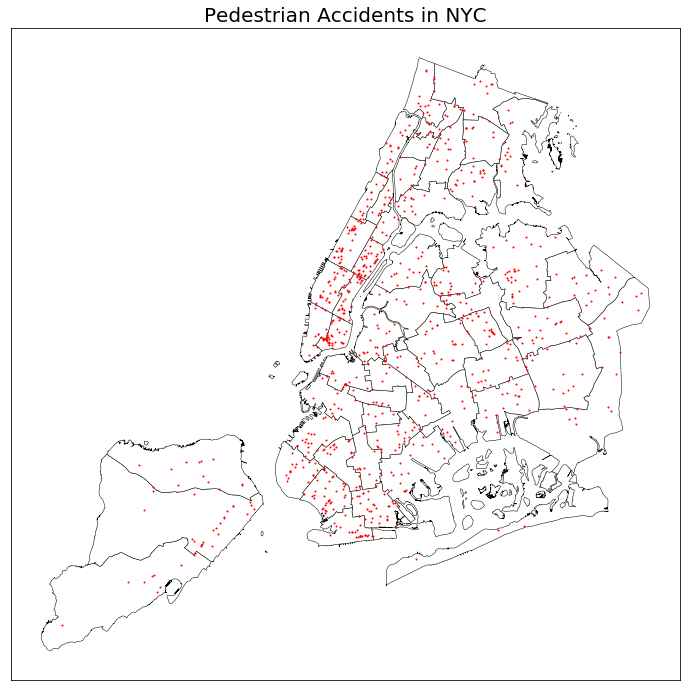

In [16]:
# Plot of all pedestrian accidents in NYC with NYC PUMAs
f, ax = plt.subplots(figsize=(12, 12))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
pumashp.plot(alpha=1,linewidth=0.5,ax=ax,color='w',edgecolor='black')
merged_sjoin.plot(ax=ax, edgecolor="r", markersize=1)
plt.title("Pedestrian Accidents in NYC", fontsize=20)
plt.show()

# Comparison with the Senior Pedestrian Focus Areas

Next, we moved on to comparing the locations of each accident with the Senior Pedestrian Focus Areas in NYC. To do this, we used the SPFA shapefile provided by NYC Open Data.

## Plotting with the Senior Pedestrian Focus Areas

First, we added rounds to indicate which round of project implementation each polygon corresponds to based on the program map seen here:

https://www1.nyc.gov/html/dot/downloads/pdf/safeseniors-citywide-map-2017.pdf

Note that "Midtown East" on the map available online corresponds to "Chelsea/9th Avenue" in this shapefile. We verified this through manual observation.

In [17]:
# Safe Streets for Seniors shapefile
spfa = gpd.GeoDataFrame.from_file('../data/vizZeroSSfSshapefile/geo_export_39b3b39b-7a20-4454-8888-016d51d9ccaf.shp')
spfa.crs = from_epsg(4326)
spfa.to_crs(epsg=4326, inplace = True)

In [18]:
spfa.head()

name    shape_area    shape_leng  \
0             Astoria  8.306479e+06  14763.582784   
1          Bath Beach  1.187964e+07  15515.138903   
2           Bay Ridge  1.475626e+07  21468.007297   
3  Bedford Stuyvesant  4.613148e+07  27438.609830   
4         Bensonhurst  2.399853e+07  23653.773218   

                                            geometry  
0  POLYGON ((-73.91898633335042 40.7657712929684,...  
1  POLYGON ((-73.9915393446876 40.59039090252011,...  
2  POLYGON ((-74.03381765235099 40.61458678694897...  
3  POLYGON ((-73.92864269098517 40.69324101224243...  
4  POLYGON ((-73.99015003215264 40.59970502428778...

In [19]:
spfa.shape

(41, 4)

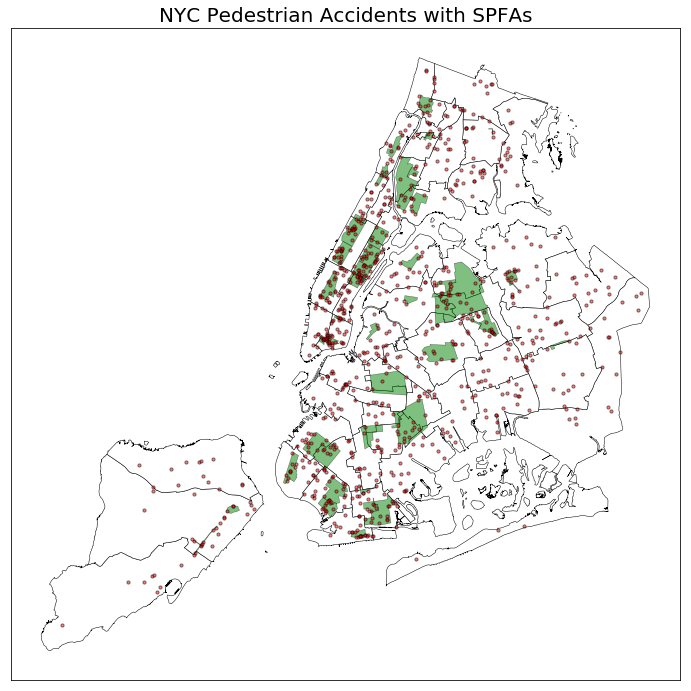

In [20]:
# Plot of accidents and SPFAs
f, ax = plt.subplots(figsize=(12,12))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# NYC PUMAs
pumashp.plot(alpha=1,linewidth=0.5,ax=ax,color='w',edgecolor='black')
# SPFAs plotted in green
spfa.plot(alpha=.5,linewidth=0.5,ax=ax,color='green',edgecolor='black')
# Pedestrian accidents plotted in red dots
merged_sjoin.plot(alpha=.5, ax=ax, facecolor="r", edgecolor="k", markersize=10)
plt.title("NYC Pedestrian Accidents with SPFAs", fontsize=20)
plt.show()

In [21]:
merged_senior = merged_sjoin[merged_sjoin["SENIOR"] != 0]

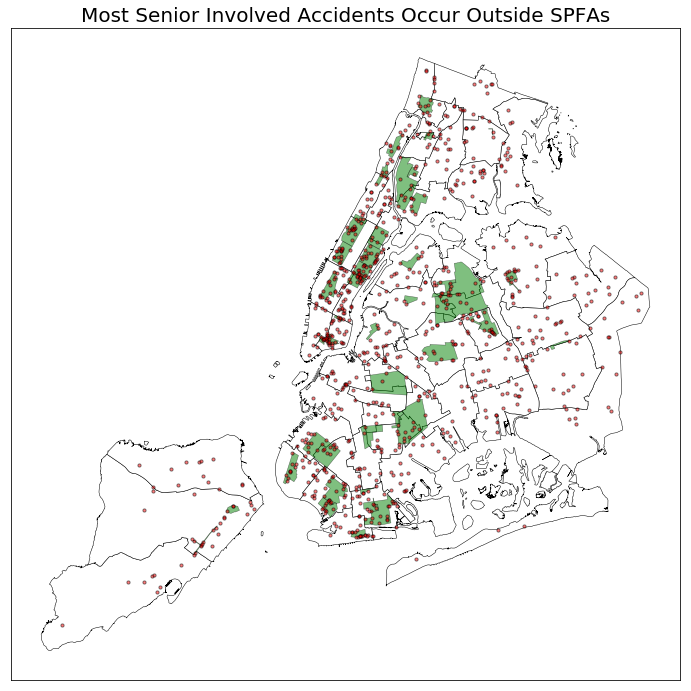

In [22]:
# Plot of accidents and SPFAs
f, ax = plt.subplots(figsize=(12,12))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# NYC PUMAs
pumashp.plot(alpha=1,linewidth=0.5,ax=ax,color='w',edgecolor='black')
# SPFAs plotted in green
spfa.plot(alpha=.5,linewidth=0.5,ax=ax,color='green',edgecolor='black')
# Pedestrian accidents plotted in red dots
merged_senior.plot(alpha=.5, ax=ax, facecolor="r", edgecolor="k", markersize=10)
plt.title("Most Senior Involved Accidents Occur Outside SPFAs", fontsize=20)
plt.show()

In [23]:
merged_senior.head()

ST_CASE_YEAR  SENIOR  S_PED  S_NOT_PED  S_PED_DEAD  S_SURVIVED  S_DEAD  \
1    360118_2001     3.0    1.0        2.0         1.0         0.0     3.0   
46   361325_2001     1.0    1.0        0.0         1.0         0.0     1.0   
95   360966_2002     1.0    1.0        0.0         1.0         0.0     1.0   
120  361302_2002     2.0    1.0        1.0         1.0         0.0     2.0   
144  360270_2003     1.0    1.0        0.0         1.0         0.0     1.0   

     S_DRINKING+  S_DRINKING-  S_MALE  S_FEMALE  S_DRUG+  S_DRUG-  \
1            0.0          1.0     3.0       0.0      0.0      1.0   
46           0.0          1.0     1.0       0.0      0.0      1.0   
95           0.0          1.0     1.0       0.0      0.0      1.0   
120          0.0          2.0     2.0       0.0      0.0      2.0   
144          0.0          1.0     0.0       1.0      0.0      1.0   

     S_DEAD_AFTER  S_DEAD_SCENE  S_DEAD_ROUTE  ALIGNMNT  ARR_HOUR  ARR_MIN  \
1             2.0           1.0           0.0       1.0      99.0     99.0   
46            1.0           0.0           0.0       1.0      99.0     99.0   
95            1.0           0.0           0.0       1.0      99.0     99.0   
120           1.0           0.0           0.0       1.0      99.0     99.0   
144           1.0           0.0           0.0       1.0      99.0     99.0   

     CF1  CF2  CF3    CITY  COUNTY  C_M_ZONE   DAY  DAY_WEEK  DRUNK_DR  \
1    0.0  0.0  0.0  4170.0    61.0       0.0  18.0       5.0       1.0   
46   0.0  0.0  0.0  4170.0    61.0       0.0   7.0       4.0       1.0   
95   0.0  0.0  0.0  4170.0    61.0       0.0  13.0       7.0       0.0   
120  0.0  0.0  0.0  4170.0    61.0       0.0   3.0       7.0       0.0   
144  0.0  0.0  0.0  4170.0    61.0       0.0  26.0       4.0       0.0   

     FATALS  FUNC_SYS  HARM_EV  HIT_RUN  HOSP_HR  HOSP_MN  HOUR   LATITUDE  \
1       1.0       NaN      8.0      0.0     99.0     99.0  16.0  40.832786   
46      1.0       NaN     18.0      0.0     99.0     99.0   3.0  40.840989   
95      1.0       NaN      8.0      0.0     99.0     99.0  10.0  40.834722   
120     1.0       NaN      8.0      0.0     99.0     99.0  18.0  40.855094   
144     1.0       NaN      8.0      0.0     99.0     99.0   9.0  40.868167   

     LGT_COND   LONGITUD  MAN_COLL  MILEPT  MINUTE  MONTH  NHS  NOT_HOUR  \
1         5.0 -73.945856       0.0     0.0    32.0    1.0  0.0      99.0   
46        3.0 -73.939533       0.0     0.0     0.0   11.0  0.0      99.0   
95        1.0 -73.940683       0.0     0.0    35.0    4.0  0.0      99.0   
120       1.0 -73.940422       0.0     0.0    16.0    8.0  1.0      99.0   
144       1.0 -73.919758       0.0     0.0    45.0    3.0  0.0      99.0   

     NOT_MIN  NO_LANES  PAVE_TYP  PEDS  PERMVIT  PERNOTMVIT  PERSONS  PROFILE  \
1       99.0       4.0       2.0   1.0      NaN         NaN      4.0      2.0   
46      99.0       2.0       2.0   1.0      NaN         NaN      2.0      1.0   
95      99.0       4.0       2.0   1.0      NaN         NaN      2.0      2.0   
120     99.0       3.0       1.0   1.0      NaN         NaN      2.0      1.0   
144     99.0       4.0       2.0   1.0      NaN         NaN      2.0      1.0   

     PVH_INVL  RAIL  RD_OWNER  RELJCT1  RELJCT2  REL_JUNC  REL_ROAD  ROAD_FNC  \
1         NaN     0       NaN      NaN      NaN       2.0       1.0      13.0   
46        NaN     0       NaN      NaN      NaN       2.0       1.0      14.0   
95        NaN     0       NaN      NaN      NaN       2.0       1.0      13.0   
120       NaN     0       NaN      NaN      NaN       1.0       1.0      12.0   
144       NaN     0       NaN      NaN      NaN       2.0       1.0      13.0   

     ROUTE  RUR_URB  SCH_BUS  SP_JUR  SP_LIMIT  STATE  ST_CASE  SUR_COND  \
1      6.0      NaN      0.0     0.0      99.0   36.0   360118       2.0   
46     6.0      NaN      0.0     0.0      99.0   36.0   361325       1.0   
95     6.0      NaN      0.0     0.0      30.0   36.0   360966       1.0   
12

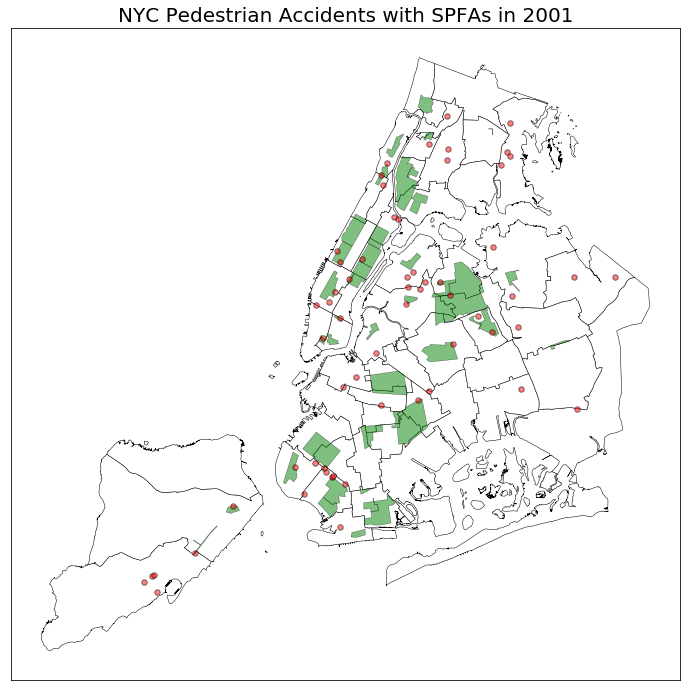

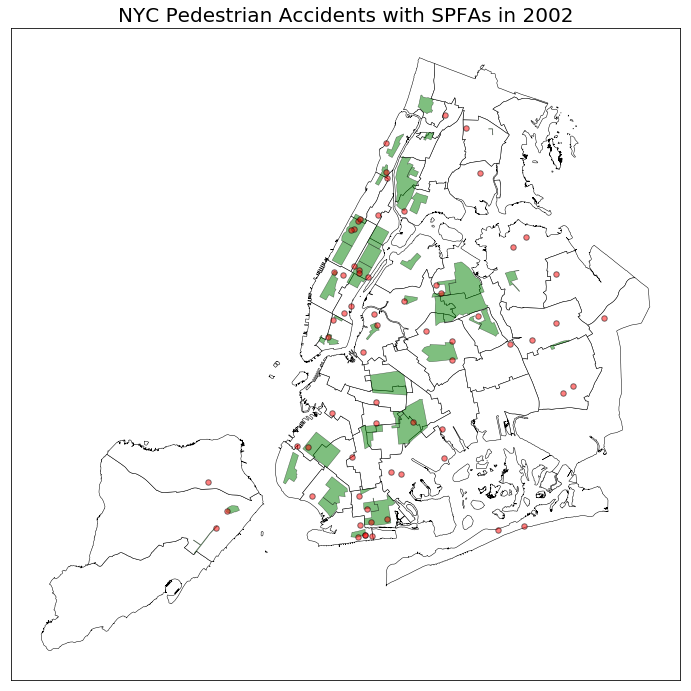

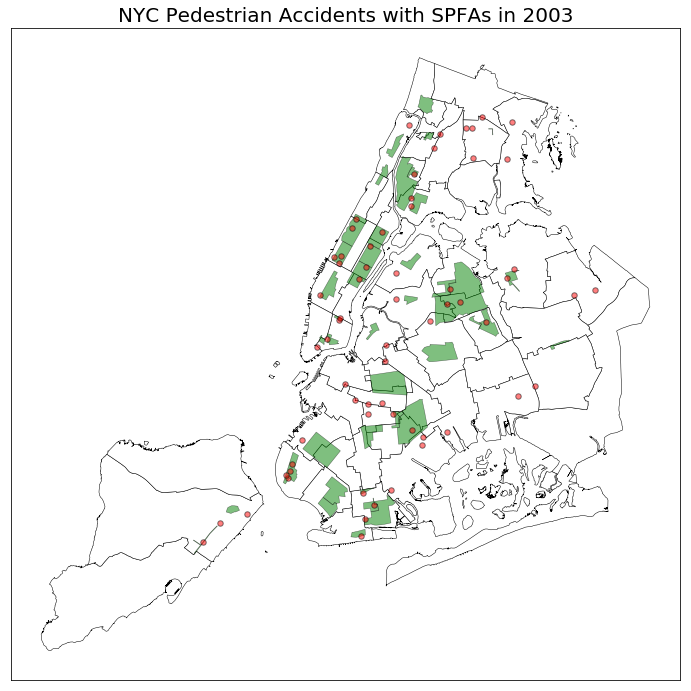

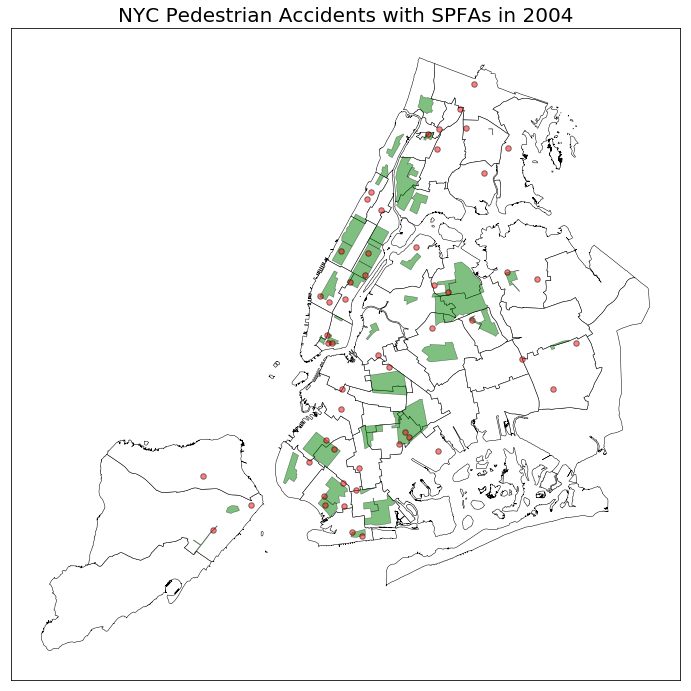

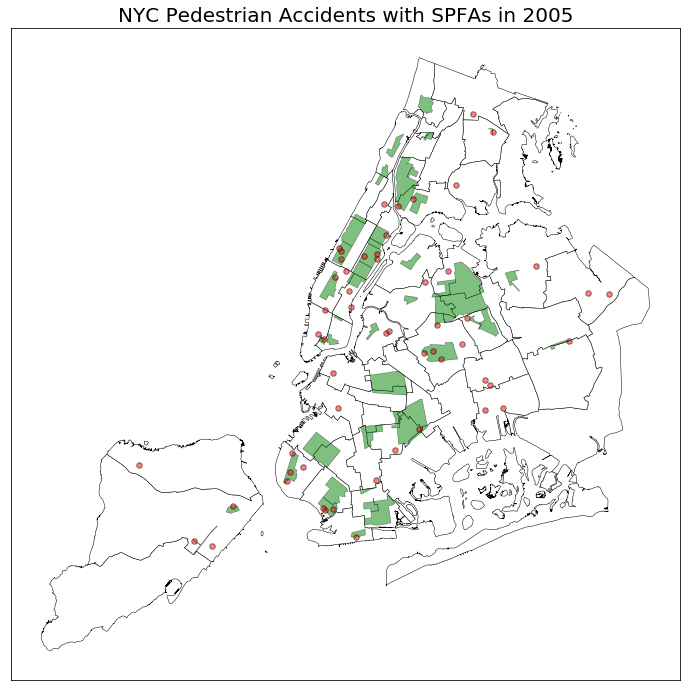

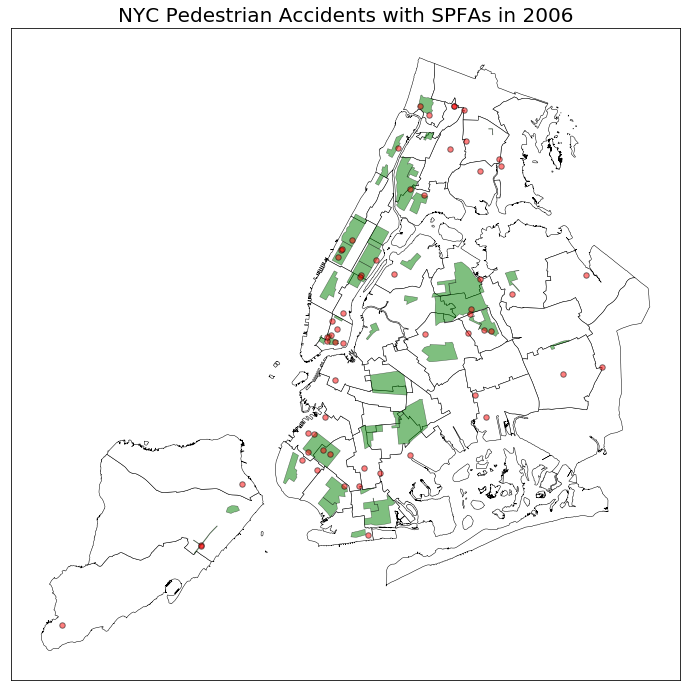

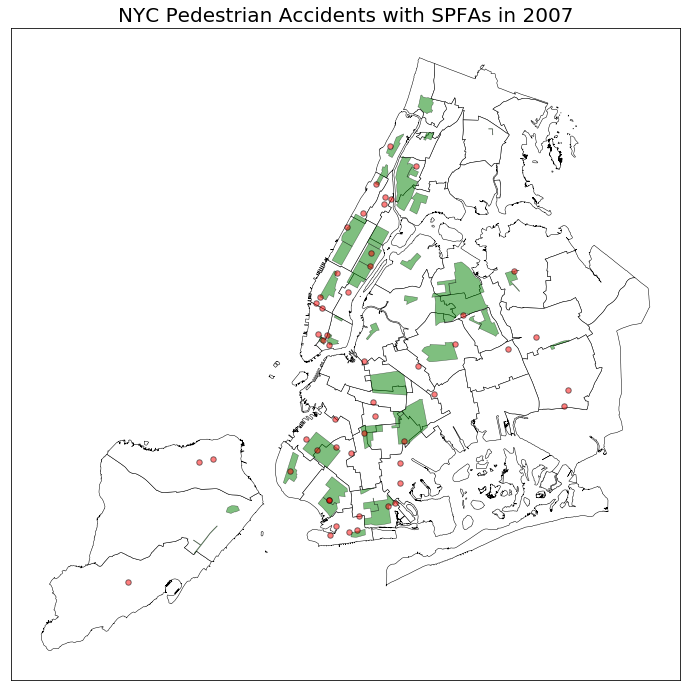

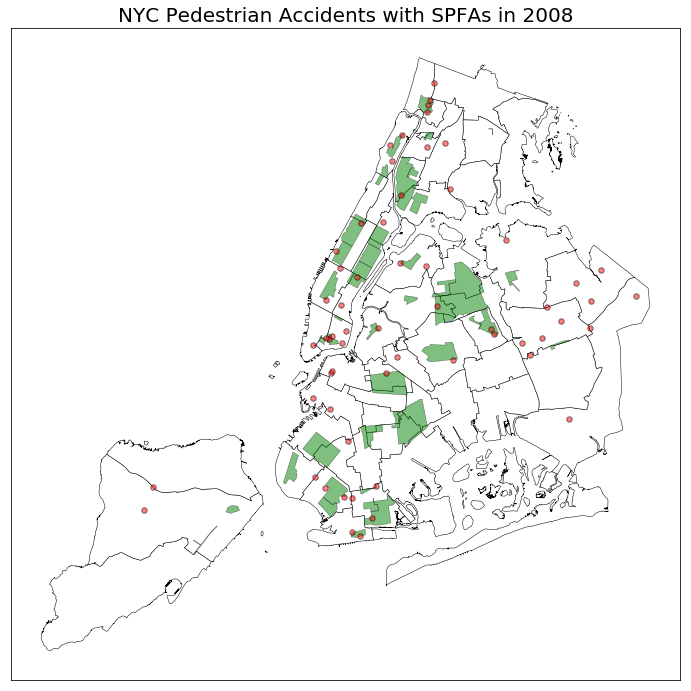

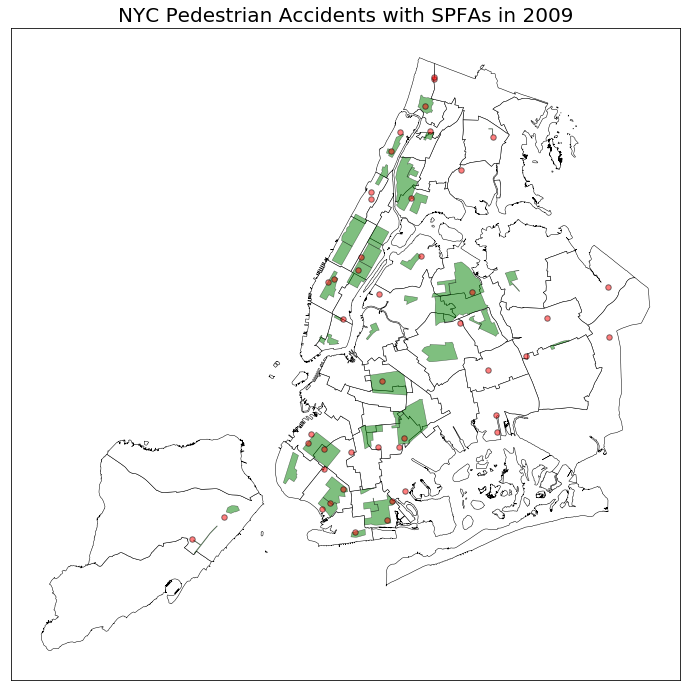

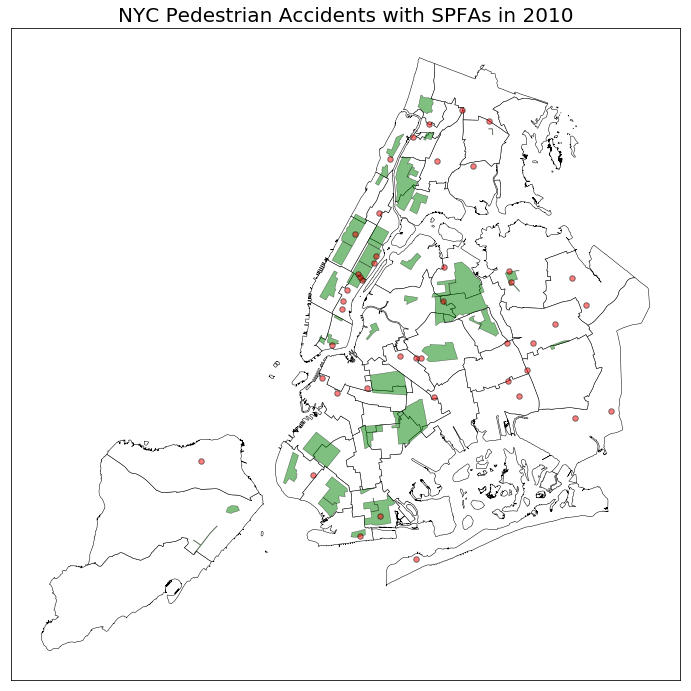

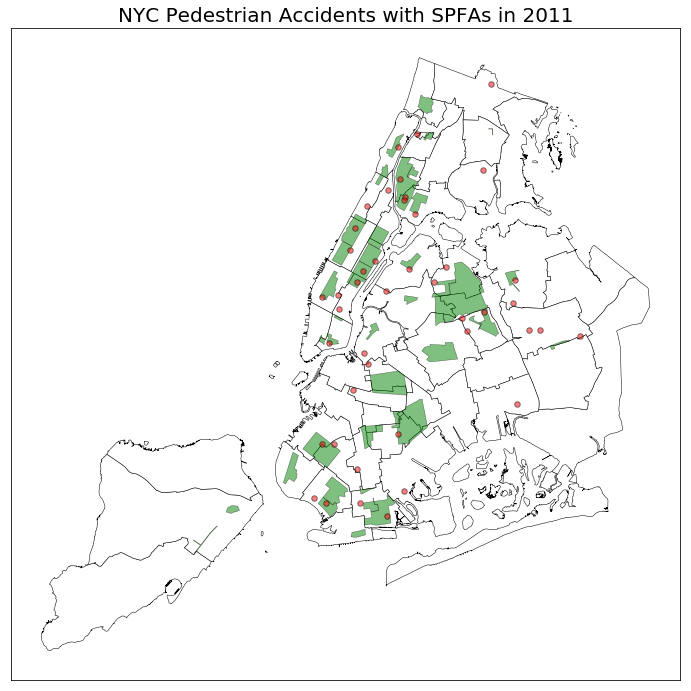

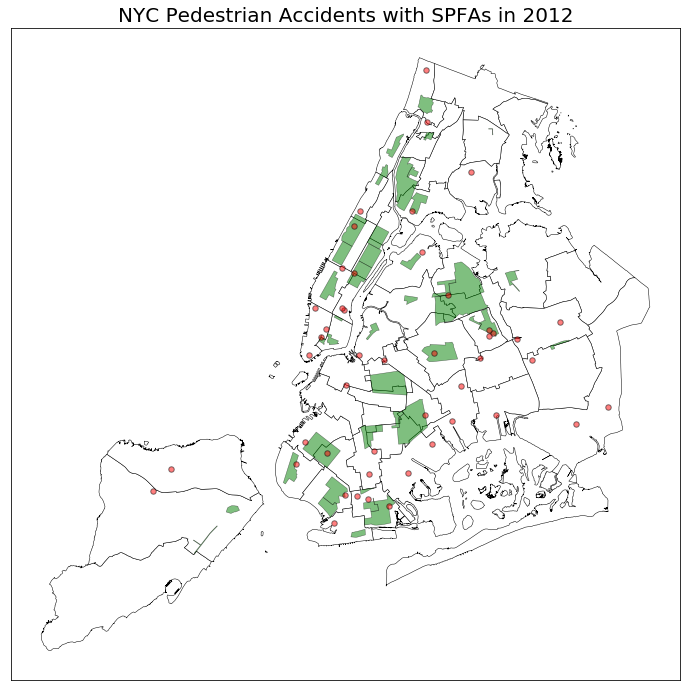

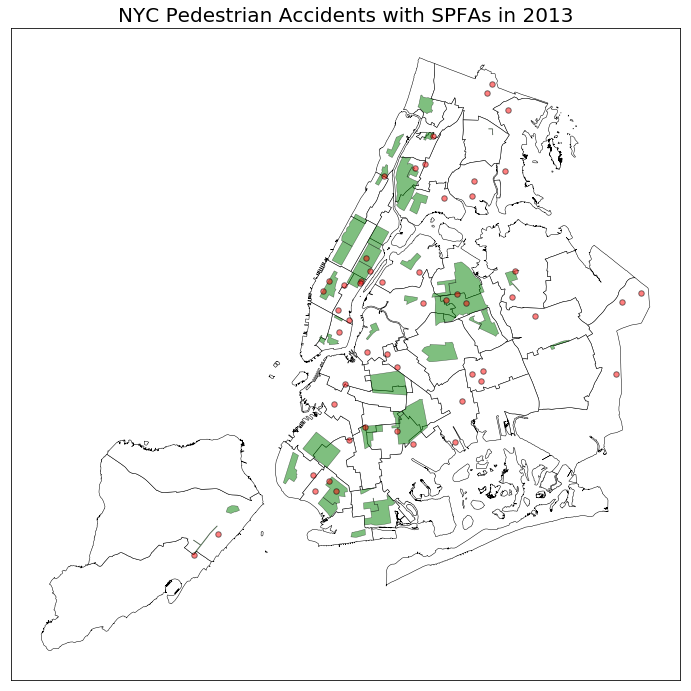

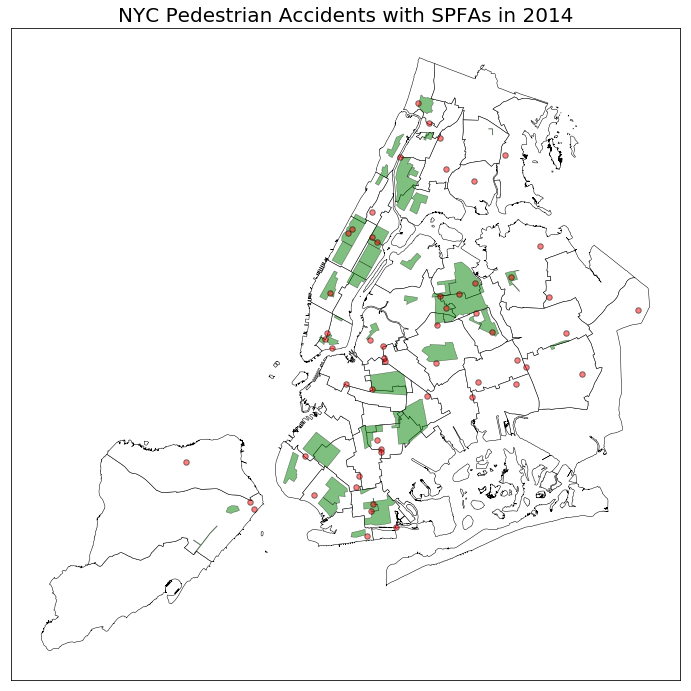

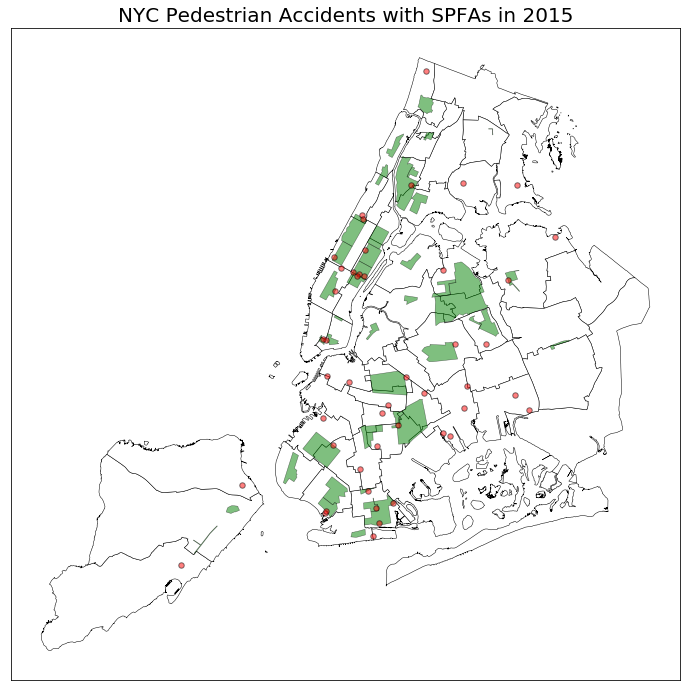

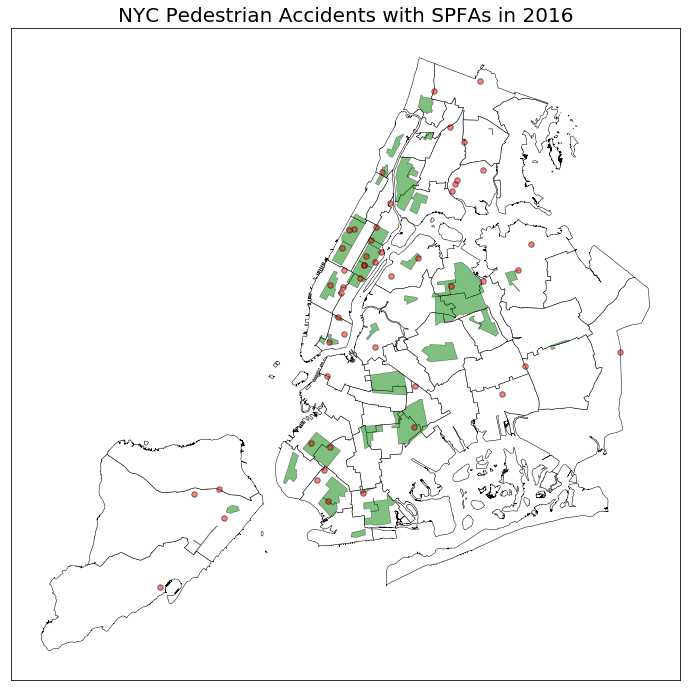

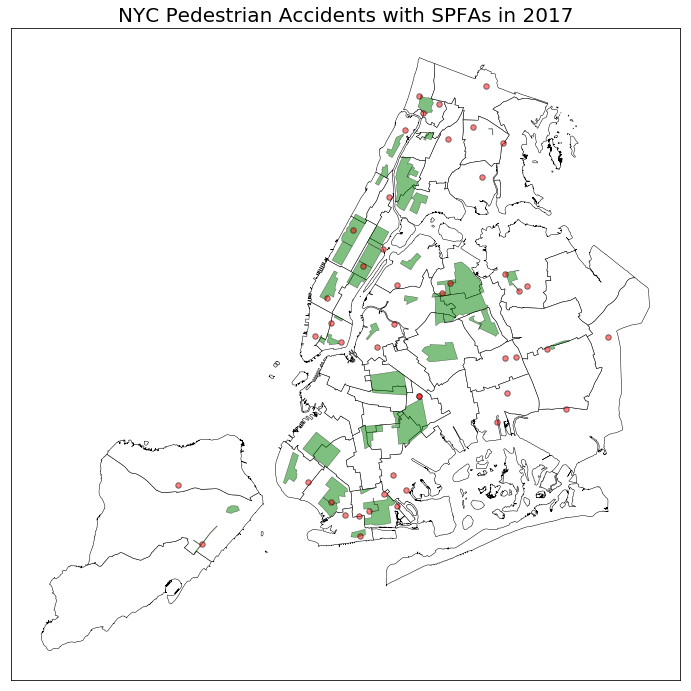

In [24]:
year = sorted(merged_sjoin['YEAR'].unique())
for i in year:
    # Plot of accidents and SPFAs
    f, ax = plt.subplots(figsize=(12,12))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    # NYC PUMAs
    pumashp.plot(alpha=1,linewidth=0.5,ax=ax,color='w',edgecolor='black')
    # SPFAs plotted in green
    spfa.plot(alpha=.5,linewidth=0.5,ax=ax,color='green',edgecolor='black')
    # Pedestrian accidents plotted in red dots
    df = merged_sjoin[merged_sjoin['YEAR']==i]
    df.plot(alpha=.5, ax=ax, facecolor="r", edgecolor="k", markersize=30)
    plt.title("NYC Pedestrian Accidents with SPFAs in " + str(i), fontsize=20)
    plt.show()

In [25]:
merged_senior.columns

Index(['ST_CASE_YEAR', 'SENIOR', 'S_PED', 'S_NOT_PED', 'S_PED_DEAD',
       'S_SURVIVED', 'S_DEAD', 'S_DRINKING+', 'S_DRINKING-', 'S_MALE',
       'S_FEMALE', 'S_DRUG+', 'S_DRUG-', 'S_DEAD_AFTER', 'S_DEAD_SCENE',
       'S_DEAD_ROUTE', 'ALIGNMNT', 'ARR_HOUR', 'ARR_MIN', 'CF1', 'CF2', 'CF3',
       'CITY', 'COUNTY', 'C_M_ZONE', 'DAY', 'DAY_WEEK', 'DRUNK_DR', 'FATALS',
       'FUNC_SYS', 'HARM_EV', 'HIT_RUN', 'HOSP_HR', 'HOSP_MN', 'HOUR',
       'LATITUDE', 'LGT_COND', 'LONGITUD', 'MAN_COLL', 'MILEPT', 'MINUTE',
       'MONTH', 'NHS', 'NOT_HOUR', 'NOT_MIN', 'NO_LANES', 'PAVE_TYP', 'PEDS',
       'PERMVIT', 'PERNOTMVIT', 'PERSONS', 'PROFILE', 'PVH_INVL', 'RAIL',
       'RD_OWNER', 'RELJCT1', 'RELJCT2', 'REL_JUNC', 'REL_ROAD', 'ROAD_FNC',
       'ROUTE', 'RUR_URB', 'SCH_BUS', 'SP_JUR', 'SP_LIMIT', 'STATE', 'ST_CASE',
       'SUR_COND', 'TRAF_FLO', 'TRA_CONT', 'TWAY_ID', 'TWAY_ID2', 'TYP_INT',
       'T_CONT_F', 'VE_FORMS', 'VE_TOTAL', 'WEATHER', 'WEATHER1', 'WEATHER2',
       'WRK_ZONE', '

## Spatial join with SPFA shapefile

Next we performed a spatial join between the NYC accidents data and the SPFA shapefile in order to determine which accidents took place in SPFAs.

In [26]:
# To cover the largest batch of SPFA zones
spfa.insert(1, 'rounds', 1)

In [27]:
# Manually adding round label to specific zones after manual review
spfa.loc[0:2,'rounds'] = 2
spfa.loc[3, 'rounds'] = 3
spfa.loc[7, 'rounds'] = 3
spfa.loc[11, 'rounds'] = 3
spfa.loc[14:15, 'rounds'] = 2
spfa.loc[18, 'rounds'] = 2
spfa.loc[21, 'rounds'] = 3
spfa.loc[24:26, 'rounds'] = 2
spfa.loc[28:29, 'rounds'] = 2
spfa.loc[36, 'rounds'] = 2

In [28]:
spfa.head()

name  rounds    shape_area    shape_leng  \
0             Astoria       2  8.306479e+06  14763.582784   
1          Bath Beach       2  1.187964e+07  15515.138903   
2           Bay Ridge       2  1.475626e+07  21468.007297   
3  Bedford Stuyvesant       3  4.613148e+07  27438.609830   
4         Bensonhurst       1  2.399853e+07  23653.773218   

                                            geometry  
0  POLYGON ((-73.91898633335042 40.7657712929684,...  
1  POLYGON ((-73.9915393446876 40.59039090252011,...  
2  POLYGON ((-74.03381765235099 40.61458678694897...  
3  POLYGON ((-73.92864269098517 40.69324101224243...  
4  POLYGON ((-73.99015003215264 40.59970502428778...

In [29]:
spfa.shape

(41, 5)

In [30]:
# Cleanup
spfa.reset_index(drop=True, inplace=True)
merged_sjoin.reset_index(drop=True, inplace=True)

In [31]:
# Sjoin with SPFAs with a left join to keep all accidents
merged_spfa = gpd.tools.sjoin(merged_sjoin,spfa,how='left')

In [32]:
# Cleanup
merged_spfa.drop(['index_right', 'shape_area', 'shape_leng'], axis=1, inplace=True)
merged_spfa.reset_index(drop=True, inplace=True)

In [33]:
merged_spfa.head()

ST_CASE_YEAR  SENIOR  S_PED  S_NOT_PED  S_PED_DEAD  S_SURVIVED  S_DEAD  \
0  360118_2001     3.0    1.0        2.0         1.0         0.0     3.0   
1  361325_2001     1.0    1.0        0.0         1.0         0.0     1.0   
2  360966_2002     1.0    1.0        0.0         1.0         0.0     1.0   
3  361302_2002     2.0    1.0        1.0         1.0         0.0     2.0   
4  360270_2003     1.0    1.0        0.0         1.0         0.0     1.0   

   S_DRINKING+  S_DRINKING-  S_MALE  S_FEMALE  S_DRUG+  S_DRUG-  S_DEAD_AFTER  \
0          0.0          1.0     3.0       0.0      0.0      1.0           2.0   
1          0.0          1.0     1.0       0.0      0.0      1.0           1.0   
2          0.0          1.0     1.0       0.0      0.0      1.0           1.0   
3          0.0          2.0     2.0       0.0      0.0      2.0           1.0   
4          0.0          1.0     0.0       1.0      0.0      1.0           1.0   

   S_DEAD_SCENE  S_DEAD_ROUTE  ALIGNMNT  ARR_HOUR  ARR_MIN  CF1  CF2  CF3  \
0           1.0           0.0       1.0      99.0     99.0  0.0  0.0  0.0   
1           0.0           0.0       1.0      99.0     99.0  0.0  0.0  0.0   
2           0.0           0.0       1.0      99.0     99.0  0.0  0.0  0.0   
3           0.0           0.0       1.0      99.0     99.0  0.0  0.0  0.0   
4           0.0           0.0       1.0      99.0     99.0  0.0  0.0  0.0   

     CITY  COUNTY  C_M_ZONE   DAY  DAY_WEEK  DRUNK_DR  FATALS  FUNC_SYS  \
0  4170.0    61.0       0.0  18.0       5.0       1.0     1.0       NaN   
1  4170.0    61.0       0.0   7.0       4.0       1.0     1.0       NaN   
2  4170.0    61.0       0.0  13.0       7.0       0.0     1.0       NaN   
3  4170.0    61.0       0.0   3.0       7.0       0.0     1.0       NaN   
4  4170.0    61.0       0.0  26.0       4.0       0.0     1.0       NaN   

   HARM_EV  HIT_RUN  HOSP_HR  HOSP_MN  HOUR   LATITUDE  LGT_COND   LONGITUD  \
0      8.0      0.0     99.0     99.0  16.0  40.832786       5.0 -73.945856   
1     18.0      0.0     99.0     99.0   3.0  40.840989       3.0 -73.939533   
2      8.0      0.0     99.0     99.0  10.0  40.834722       1.0 -73.940683   
3      8.0      0.0     99.0     99.0  18.0  40.855094       1.0 -73.940422   
4      8.0      0.0     99.0     99.0   9.0  40.868167       1.0 -73.919758   

   MAN_COLL  MILEPT  MINUTE  MONTH  NHS  NOT_HOUR  NOT_MIN  NO_LANES  \
0       0.0     0.0    32.0    1.0  0.0      99.0     99.0       4.0   
1       0.0     0.0     0.0   11.0  0.0      99.0     99.0       2.0   
2       0.0     0.0    35.0    4.0  0.0      99.0     99.0       4.0   
3       0.0     0.0    16.0    8.0  1.0      99.0     99.0       3.0   
4       0.0     0.0    45.0    3.0  0.0      99.0     99.0       4.0   

   PAVE_TYP  PEDS  PERMVIT  PERNOTMVIT  PERSONS  PROFILE  PVH_INVL  RAIL  \
0       2.0   1.0      NaN         NaN      4.0      2.0       NaN     0   
1       2.0   1.0      NaN         NaN      2.0      1.0       NaN     0   
2       2.0   1.0      NaN         NaN      2.0      2.0       NaN     0   
3       1.0   1.0      NaN         NaN      2.0      1.0       NaN     0   
4       2.0   1.0      NaN         NaN      2.0      1.0       NaN     0   

   RD_OWNER  RELJCT1  RELJCT2  REL_JUNC  REL_ROAD  ROAD_FNC  ROUTE  RUR_URB  \
0       NaN      NaN      NaN       2.0       1.0      13.0    6.0      NaN   
1       NaN      NaN      NaN       2.0       1.0      14.0    6.0      NaN   
2       NaN      NaN      NaN       2.0       1.0      13.0    6.0      NaN   
3       NaN      NaN      NaN       1.0       1.0      12.0    8.0      NaN   
4       NaN      NaN      NaN       2.0       1.0      13.0    6.0      NaN   

   SCH_BUS  SP_JUR  SP_LIMIT  STATE  ST_CASE  SUR_COND  TRAF_FLO  TRA_CONT  \
0      0.0     0.0      99.0   36.0   360118       2.0       1.0       3.0   
1      0.0     0.0      99.0   36.0   361325       1.0       1.0       3.0   
2      0.0     0.0      30.0   36.0   360966       1.0       1.0      

In [34]:
merged_spfa.shape

(907, 86)

## Create dummy variables for each round from the SPFA program

In [35]:
merged_spfa = pd.get_dummies(merged_spfa, columns=['rounds'])
merged_spfa.head()

ST_CASE_YEAR  SENIOR  S_PED  S_NOT_PED  S_PED_DEAD  S_SURVIVED  S_DEAD  \
0  360118_2001     3.0    1.0        2.0         1.0         0.0     3.0   
1  361325_2001     1.0    1.0        0.0         1.0         0.0     1.0   
2  360966_2002     1.0    1.0        0.0         1.0         0.0     1.0   
3  361302_2002     2.0    1.0        1.0         1.0         0.0     2.0   
4  360270_2003     1.0    1.0        0.0         1.0         0.0     1.0   

   S_DRINKING+  S_DRINKING-  S_MALE  S_FEMALE  S_DRUG+  S_DRUG-  S_DEAD_AFTER  \
0          0.0          1.0     3.0       0.0      0.0      1.0           2.0   
1          0.0          1.0     1.0       0.0      0.0      1.0           1.0   
2          0.0          1.0     1.0       0.0      0.0      1.0           1.0   
3          0.0          2.0     2.0       0.0      0.0      2.0           1.0   
4          0.0          1.0     0.0       1.0      0.0      1.0           1.0   

   S_DEAD_SCENE  S_DEAD_ROUTE  ALIGNMNT  ARR_HOUR  ARR_MIN  CF1  CF2  CF3  \
0           1.0           0.0       1.0      99.0     99.0  0.0  0.0  0.0   
1           0.0           0.0       1.0      99.0     99.0  0.0  0.0  0.0   
2           0.0           0.0       1.0      99.0     99.0  0.0  0.0  0.0   
3           0.0           0.0       1.0      99.0     99.0  0.0  0.0  0.0   
4           0.0           0.0       1.0      99.0     99.0  0.0  0.0  0.0   

     CITY  COUNTY  C_M_ZONE   DAY  DAY_WEEK  DRUNK_DR  FATALS  FUNC_SYS  \
0  4170.0    61.0       0.0  18.0       5.0       1.0     1.0       NaN   
1  4170.0    61.0       0.0   7.0       4.0       1.0     1.0       NaN   
2  4170.0    61.0       0.0  13.0       7.0       0.0     1.0       NaN   
3  4170.0    61.0       0.0   3.0       7.0       0.0     1.0       NaN   
4  4170.0    61.0       0.0  26.0       4.0       0.0     1.0       NaN   

   HARM_EV  HIT_RUN  HOSP_HR  HOSP_MN  HOUR   LATITUDE  LGT_COND   LONGITUD  \
0      8.0      0.0     99.0     99.0  16.0  40.832786       5.0 -73.945856   
1     18.0      0.0     99.0     99.0   3.0  40.840989       3.0 -73.939533   
2      8.0      0.0     99.0     99.0  10.0  40.834722       1.0 -73.940683   
3      8.0      0.0     99.0     99.0  18.0  40.855094       1.0 -73.940422   
4      8.0      0.0     99.0     99.0   9.0  40.868167       1.0 -73.919758   

   MAN_COLL  MILEPT  MINUTE  MONTH  NHS  NOT_HOUR  NOT_MIN  NO_LANES  \
0       0.0     0.0    32.0    1.0  0.0      99.0     99.0       4.0   
1       0.0     0.0     0.0   11.0  0.0      99.0     99.0       2.0   
2       0.0     0.0    35.0    4.0  0.0      99.0     99.0       4.0   
3       0.0     0.0    16.0    8.0  1.0      99.0     99.0       3.0   
4       0.0     0.0    45.0    3.0  0.0      99.0     99.0       4.0   

   PAVE_TYP  PEDS  PERMVIT  PERNOTMVIT  PERSONS  PROFILE  PVH_INVL  RAIL  \
0       2.0   1.0      NaN         NaN      4.0      2.0       NaN     0   
1       2.0   1.0      NaN         NaN      2.0      1.0       NaN     0   
2       2.0   1.0      NaN         NaN      2.0      2.0       NaN     0   
3       1.0   1.0      NaN         NaN      2.0      1.0       NaN     0   
4       2.0   1.0      NaN         NaN      2.0      1.0       NaN     0   

   RD_OWNER  RELJCT1  RELJCT2  REL_JUNC  REL_ROAD  ROAD_FNC  ROUTE  RUR_URB  \
0       NaN      NaN      NaN       2.0       1.0      13.0    6.0      NaN   
1       NaN      NaN      NaN       2.0       1.0      14.0    6.0      NaN   
2       NaN      NaN      NaN       2.0       1.0      13.0    6.0      NaN   
3       NaN      NaN      NaN       1.0       1.0      12.0    8.0      NaN   
4       NaN      NaN      NaN       2.0       1.0      13.0    6.0      NaN   

   SCH_BUS  SP_JUR  SP_LIMIT  STATE  ST_CASE  SUR_COND  TRAF_FLO  TRA_CONT  \
0      0.0     0.0      99.0   36.0   360118       2.0       1.0       3.0   
1      0.0     0.0      99.0   36.0   361325       1.0       1.0       3.0   
2      0.0     0.0      30.0   36.0   360966       1.0       1.0      

In [36]:
for i in range(1,4):
    print("Total number of accidents that have occurred within round {} zones: {}".format(i, \
                                                                   merged_spfa['rounds_{}.0'.format(i)].sum()))


Total number of accidents that have occurred within round 1 zones: 127
Total number of accidents that have occurred within round 2 zones: 100
Total number of accidents that have occurred within round 3 zones: 37


In [37]:
"""
Create a separate column indicating whether or not each accident that occurred in an SPFA took place after the
SPFA was implemented (True indicates that it did occur in an SPFA after it was implemented)
"""
merged_spfa['acc_post_spfa'] = (((merged_spfa['rounds_1.0']==1) & (merged_spfa['YEAR']>=2008)) | \
                               ((merged_spfa['rounds_2.0']==1) & (merged_spfa['YEAR']>=2012)) | \
                               ((merged_spfa['rounds_3.0']==1) & (merged_spfa['YEAR']>=2017)))

In [38]:
"""
Create a column indicating whether or not an accident occurred within an SPFA or not (True indicates that it did 
occur in an SPFA)
"""
merged_spfa['name'] = merged_spfa['name'].astype(str)
merged_spfa['in_spfa'] = merged_spfa['name'] != 'nan'

In [39]:
merged_spfa.head()

ST_CASE_YEAR  SENIOR  S_PED  S_NOT_PED  S_PED_DEAD  S_SURVIVED  S_DEAD  \
0  360118_2001     3.0    1.0        2.0         1.0         0.0     3.0   
1  361325_2001     1.0    1.0        0.0         1.0         0.0     1.0   
2  360966_2002     1.0    1.0        0.0         1.0         0.0     1.0   
3  361302_2002     2.0    1.0        1.0         1.0         0.0     2.0   
4  360270_2003     1.0    1.0        0.0         1.0         0.0     1.0   

   S_DRINKING+  S_DRINKING-  S_MALE  S_FEMALE  S_DRUG+  S_DRUG-  S_DEAD_AFTER  \
0          0.0          1.0     3.0       0.0      0.0      1.0           2.0   
1          0.0          1.0     1.0       0.0      0.0      1.0           1.0   
2          0.0          1.0     1.0       0.0      0.0      1.0           1.0   
3          0.0          2.0     2.0       0.0      0.0      2.0           1.0   
4          0.0          1.0     0.0       1.0      0.0      1.0           1.0   

   S_DEAD_SCENE  S_DEAD_ROUTE  ALIGNMNT  ARR_HOUR  ARR_MIN  CF1  CF2  CF3  \
0           1.0           0.0       1.0      99.0     99.0  0.0  0.0  0.0   
1           0.0           0.0       1.0      99.0     99.0  0.0  0.0  0.0   
2           0.0           0.0       1.0      99.0     99.0  0.0  0.0  0.0   
3           0.0           0.0       1.0      99.0     99.0  0.0  0.0  0.0   
4           0.0           0.0       1.0      99.0     99.0  0.0  0.0  0.0   

     CITY  COUNTY  C_M_ZONE   DAY  DAY_WEEK  DRUNK_DR  FATALS  FUNC_SYS  \
0  4170.0    61.0       0.0  18.0       5.0       1.0     1.0       NaN   
1  4170.0    61.0       0.0   7.0       4.0       1.0     1.0       NaN   
2  4170.0    61.0       0.0  13.0       7.0       0.0     1.0       NaN   
3  4170.0    61.0       0.0   3.0       7.0       0.0     1.0       NaN   
4  4170.0    61.0       0.0  26.0       4.0       0.0     1.0       NaN   

   HARM_EV  HIT_RUN  HOSP_HR  HOSP_MN  HOUR   LATITUDE  LGT_COND   LONGITUD  \
0      8.0      0.0     99.0     99.0  16.0  40.832786       5.0 -73.945856   
1     18.0      0.0     99.0     99.0   3.0  40.840989       3.0 -73.939533   
2      8.0      0.0     99.0     99.0  10.0  40.834722       1.0 -73.940683   
3      8.0      0.0     99.0     99.0  18.0  40.855094       1.0 -73.940422   
4      8.0      0.0     99.0     99.0   9.0  40.868167       1.0 -73.919758   

   MAN_COLL  MILEPT  MINUTE  MONTH  NHS  NOT_HOUR  NOT_MIN  NO_LANES  \
0       0.0     0.0    32.0    1.0  0.0      99.0     99.0       4.0   
1       0.0     0.0     0.0   11.0  0.0      99.0     99.0       2.0   
2       0.0     0.0    35.0    4.0  0.0      99.0     99.0       4.0   
3       0.0     0.0    16.0    8.0  1.0      99.0     99.0       3.0   
4       0.0     0.0    45.0    3.0  0.0      99.0     99.0       4.0   

   PAVE_TYP  PEDS  PERMVIT  PERNOTMVIT  PERSONS  PROFILE  PVH_INVL  RAIL  \
0       2.0   1.0      NaN         NaN      4.0      2.0       NaN     0   
1       2.0   1.0      NaN         NaN      2.0      1.0       NaN     0   
2       2.0   1.0      NaN         NaN      2.0      2.0       NaN     0   
3       1.0   1.0      NaN         NaN      2.0      1.0       NaN     0   
4       2.0   1.0      NaN         NaN      2.0      1.0       NaN     0   

   RD_OWNER  RELJCT1  RELJCT2  REL_JUNC  REL_ROAD  ROAD_FNC  ROUTE  RUR_URB  \
0       NaN      NaN      NaN       2.0       1.0      13.0    6.0      NaN   
1       NaN      NaN      NaN       2.0       1.0      14.0    6.0      NaN   
2       NaN      NaN      NaN       2.0       1.0      13.0    6.0      NaN   
3       NaN      NaN      NaN       1.0       1.0      12.0    8.0      NaN   
4       NaN      NaN      NaN       2.0       1.0      13.0    6.0      NaN   

   SCH_BUS  SP_JUR  SP_LIMIT  STATE  ST_CASE  SUR_COND  TRAF_FLO  TRA_CONT  \
0      0.0     0.0      99.0   36.0   360118       2.0       1.0       3.0   
1      0.0     0.0      99.0   36.0   361325       1.0       1.0       3.0   
2      0.0     0.0      30.0   36.0   360966       1.0       1.0      

In [40]:
merged_spfa.columns.values

array(['ST_CASE_YEAR', 'SENIOR', 'S_PED', 'S_NOT_PED', 'S_PED_DEAD',
       'S_SURVIVED', 'S_DEAD', 'S_DRINKING+', 'S_DRINKING-', 'S_MALE',
       'S_FEMALE', 'S_DRUG+', 'S_DRUG-', 'S_DEAD_AFTER', 'S_DEAD_SCENE',
       'S_DEAD_ROUTE', 'ALIGNMNT', 'ARR_HOUR', 'ARR_MIN', 'CF1', 'CF2',
       'CF3', 'CITY', 'COUNTY', 'C_M_ZONE', 'DAY', 'DAY_WEEK', 'DRUNK_DR',
       'FATALS', 'FUNC_SYS', 'HARM_EV', 'HIT_RUN', 'HOSP_HR', 'HOSP_MN',
       'HOUR', 'LATITUDE', 'LGT_COND', 'LONGITUD', 'MAN_COLL', 'MILEPT',
       'MINUTE', 'MONTH', 'NHS', 'NOT_HOUR', 'NOT_MIN', 'NO_LANES',
       'PAVE_TYP', 'PEDS', 'PERMVIT', 'PERNOTMVIT', 'PERSONS', 'PROFILE',
       'PVH_INVL', 'RAIL', 'RD_OWNER', 'RELJCT1', 'RELJCT2', 'REL_JUNC',
       'REL_ROAD', 'ROAD_FNC', 'ROUTE', 'RUR_URB', 'SCH_BUS', 'SP_JUR',
       'SP_LIMIT', 'STATE', 'ST_CASE', 'SUR_COND', 'TRAF_FLO', 'TRA_CONT',
       'TWAY_ID', 'TWAY_ID2', 'TYP_INT', 'T_CONT_F', 'VE_FORMS',
       'VE_TOTAL', 'WEATHER', 'WEATHER1', 'WEATHER2', 'WRK_ZONE', '

In [41]:
merged_spfa.dtypes

ST_CASE_YEAR      object
SENIOR           float64
S_PED            float64
S_NOT_PED        float64
S_PED_DEAD       float64
S_SURVIVED       float64
S_DEAD           float64
S_DRINKING+      float64
S_DRINKING-      float64
S_MALE           float64
S_FEMALE         float64
S_DRUG+          float64
S_DRUG-          float64
S_DEAD_AFTER     float64
S_DEAD_SCENE     float64
S_DEAD_ROUTE     float64
ALIGNMNT         float64
ARR_HOUR         float64
ARR_MIN          float64
CF1              float64
CF2              float64
CF3              float64
CITY             float64
COUNTY           float64
C_M_ZONE         float64
DAY              float64
DAY_WEEK         float64
DRUNK_DR         float64
FATALS           float64
FUNC_SYS         float64
                  ...   
ROUTE            float64
RUR_URB          float64
SCH_BUS          float64
SP_JUR           float64
SP_LIMIT         float64
STATE            float64
ST_CASE            int64
SUR_COND         float64
TRAF_FLO         float64


In [42]:
merged_spfa['acc_post_spfa'] = merged_spfa['acc_post_spfa'].astype('int')
merged_spfa['in_spfa'] = merged_spfa['in_spfa'].astype('int')

In [49]:
type(merged_spfa)

geopandas.geodataframe.GeoDataFrame

In [51]:
# merged_spfa.to_csv("../data/merged_spfa.csv")
# merged_spfa.to_file("merged_spfa")


In [52]:
print("Number of accidents that occurred within any SPFA zone after that SPFA zone was implemented: " + \
      str(np.count_nonzero(merged_spfa['acc_post_spfa'])))

Number of accidents that occurred within any SPFA zone after that SPFA zone was implemented: 88


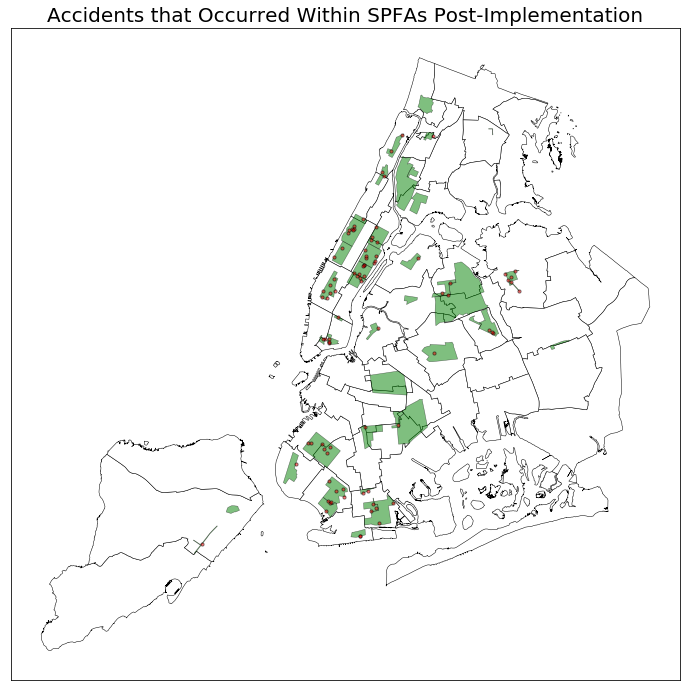

In [53]:
# Plot of accidents in SPFAs
f, ax = plt.subplots(figsize=(12,12))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# NYC PUMAs
pumashp.plot(alpha=1,linewidth=0.5,ax=ax,color='w',edgecolor='black')
# SPFAs plotted in green
spfa.plot(alpha=.5,linewidth=0.5,ax=ax,color='green',edgecolor='black')
# Pedestrian accidents plotted in red dots
merged_spfa[merged_spfa['acc_post_spfa']==1].plot(alpha=.5, ax=ax, facecolor="r", edgecolor="k", markersize=10)
plt.title("Accidents that Occurred Within SPFAs Post-Implementation", fontsize=20)
plt.show()

In [54]:
merged_spfa[merged_spfa['SENIOR']!=0].count()

ST_CASE_YEAR     907
SENIOR           907
S_PED            907
S_NOT_PED        907
S_PED_DEAD       907
S_SURVIVED       907
S_DEAD           907
S_DRINKING+      907
S_DRINKING-      907
S_MALE           907
S_FEMALE         907
S_DRUG+          907
S_DRUG-          907
S_DEAD_AFTER     907
S_DEAD_SCENE     907
S_DEAD_ROUTE     907
ALIGNMNT         519
ARR_HOUR         907
ARR_MIN          907
CF1              907
CF2              907
CF3              907
CITY             907
COUNTY           907
C_M_ZONE         474
DAY              907
DAY_WEEK         907
DRUNK_DR         907
FATALS           907
FUNC_SYS         144
                ... 
ROUTE            907
RUR_URB          144
SCH_BUS          907
SP_JUR           907
SP_LIMIT         519
STATE            907
ST_CASE          907
SUR_COND         519
TRAF_FLO         519
TRA_CONT         519
TWAY_ID          907
TWAY_ID2         617
TYP_INT          388
T_CONT_F         519
VE_FORMS         907
VE_TOTAL         662
WEATHER      

In [55]:
merged_spfa.head()

ST_CASE_YEAR  SENIOR  S_PED  S_NOT_PED  S_PED_DEAD  S_SURVIVED  S_DEAD  \
0  360118_2001     3.0    1.0        2.0         1.0         0.0     3.0   
1  361325_2001     1.0    1.0        0.0         1.0         0.0     1.0   
2  360966_2002     1.0    1.0        0.0         1.0         0.0     1.0   
3  361302_2002     2.0    1.0        1.0         1.0         0.0     2.0   
4  360270_2003     1.0    1.0        0.0         1.0         0.0     1.0   

   S_DRINKING+  S_DRINKING-  S_MALE  S_FEMALE  S_DRUG+  S_DRUG-  S_DEAD_AFTER  \
0          0.0          1.0     3.0       0.0      0.0      1.0           2.0   
1          0.0          1.0     1.0       0.0      0.0      1.0           1.0   
2          0.0          1.0     1.0       0.0      0.0      1.0           1.0   
3          0.0          2.0     2.0       0.0      0.0      2.0           1.0   
4          0.0          1.0     0.0       1.0      0.0      1.0           1.0   

   S_DEAD_SCENE  S_DEAD_ROUTE  ALIGNMNT  ARR_HOUR  ARR_MIN  CF1  CF2  CF3  \
0           1.0           0.0       1.0      99.0     99.0  0.0  0.0  0.0   
1           0.0           0.0       1.0      99.0     99.0  0.0  0.0  0.0   
2           0.0           0.0       1.0      99.0     99.0  0.0  0.0  0.0   
3           0.0           0.0       1.0      99.0     99.0  0.0  0.0  0.0   
4           0.0           0.0       1.0      99.0     99.0  0.0  0.0  0.0   

     CITY  COUNTY  C_M_ZONE   DAY  DAY_WEEK  DRUNK_DR  FATALS  FUNC_SYS  \
0  4170.0    61.0       0.0  18.0       5.0       1.0     1.0       NaN   
1  4170.0    61.0       0.0   7.0       4.0       1.0     1.0       NaN   
2  4170.0    61.0       0.0  13.0       7.0       0.0     1.0       NaN   
3  4170.0    61.0       0.0   3.0       7.0       0.0     1.0       NaN   
4  4170.0    61.0       0.0  26.0       4.0       0.0     1.0       NaN   

   HARM_EV  HIT_RUN  HOSP_HR  HOSP_MN  HOUR   LATITUDE  LGT_COND   LONGITUD  \
0      8.0      0.0     99.0     99.0  16.0  40.832786       5.0 -73.945856   
1     18.0      0.0     99.0     99.0   3.0  40.840989       3.0 -73.939533   
2      8.0      0.0     99.0     99.0  10.0  40.834722       1.0 -73.940683   
3      8.0      0.0     99.0     99.0  18.0  40.855094       1.0 -73.940422   
4      8.0      0.0     99.0     99.0   9.0  40.868167       1.0 -73.919758   

   MAN_COLL  MILEPT  MINUTE  MONTH  NHS  NOT_HOUR  NOT_MIN  NO_LANES  \
0       0.0     0.0    32.0    1.0  0.0      99.0     99.0       4.0   
1       0.0     0.0     0.0   11.0  0.0      99.0     99.0       2.0   
2       0.0     0.0    35.0    4.0  0.0      99.0     99.0       4.0   
3       0.0     0.0    16.0    8.0  1.0      99.0     99.0       3.0   
4       0.0     0.0    45.0    3.0  0.0      99.0     99.0       4.0   

   PAVE_TYP  PEDS  PERMVIT  PERNOTMVIT  PERSONS  PROFILE  PVH_INVL  RAIL  \
0       2.0   1.0      NaN         NaN      4.0      2.0       NaN     0   
1       2.0   1.0      NaN         NaN      2.0      1.0       NaN     0   
2       2.0   1.0      NaN         NaN      2.0      2.0       NaN     0   
3       1.0   1.0      NaN         NaN      2.0      1.0       NaN     0   
4       2.0   1.0      NaN         NaN      2.0      1.0       NaN     0   

   RD_OWNER  RELJCT1  RELJCT2  REL_JUNC  REL_ROAD  ROAD_FNC  ROUTE  RUR_URB  \
0       NaN      NaN      NaN       2.0       1.0      13.0    6.0      NaN   
1       NaN      NaN      NaN       2.0       1.0      14.0    6.0      NaN   
2       NaN      NaN      NaN       2.0       1.0      13.0    6.0      NaN   
3       NaN      NaN      NaN       1.0       1.0      12.0    8.0      NaN   
4       NaN      NaN      NaN       2.0       1.0      13.0    6.0      NaN   

   SCH_BUS  SP_JUR  SP_LIMIT  STATE  ST_CASE  SUR_COND  TRAF_FLO  TRA_CONT  \
0      0.0     0.0      99.0   36.0   360118       2.0       1.0       3.0   
1      0.0     0.0      99.0   36.0   361325       1.0       1.0       3.0   
2      0.0     0.0      30.0   36.0   360966       1.0       1.0      

In [56]:
# merged_spfa.to_file('data/cleanData/merged_spfa.shp')

In [57]:
spfa_senior = merged_spfa[merged_spfa["SENIOR"] != 0]

In [58]:
spfa_senior.shape

(907, 90)

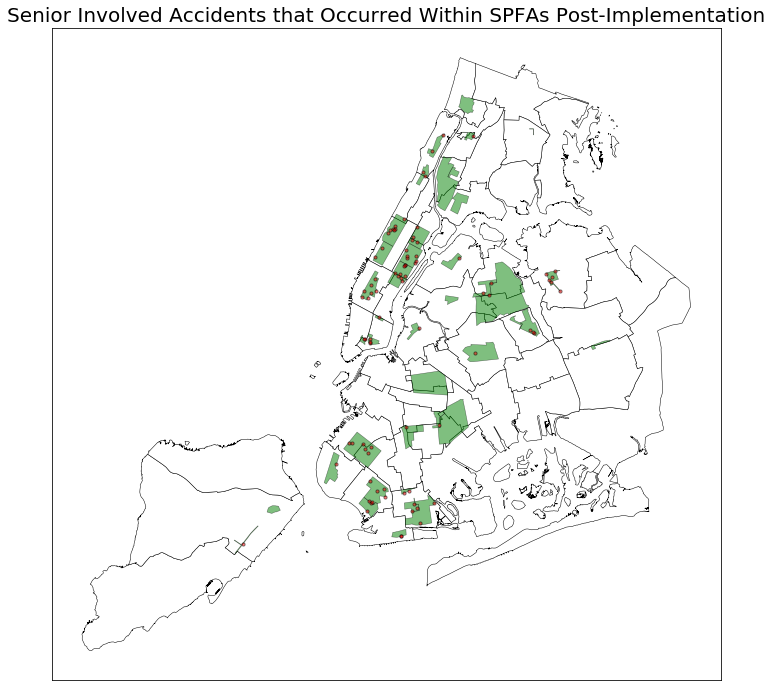

In [59]:
# Plot of accidents in SPFAs
f, ax = plt.subplots(figsize=(12,12))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# NYC PUMAs
pumashp.plot(alpha=1,linewidth=0.5,ax=ax,color='w',edgecolor='black')
# SPFAs plotted in green
spfa.plot(alpha=.5,linewidth=0.5,ax=ax,color='green',edgecolor='black')
# Pedestrian accidents plotted in red dots
spfa_senior[spfa_senior['acc_post_spfa']==1].plot(alpha=.5, ax=ax, facecolor="r", edgecolor="k", markersize=10)
plt.title("Senior Involved Accidents that Occurred Within SPFAs Post-Implementation", fontsize=20)
plt.show()

In [60]:
spfa_senior[spfa_senior['acc_post_spfa']==1].shape

(88, 90)

Exception ignored in: <bound method Collection.__del__ of <open Collection '/projects/cps2019_aging/shared/vizNB/data/merged_spfa:merged_spfa', mode 'w' at 0x7fc3b62d8cc0>>
Traceback (most recent call last):
  File "/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/fiona/collection.py", line 416, in __del__
    self.__exit__(None, None, None)
  File "/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/fiona/collection.py", line 411, in __exit__
    self.close()
  File "/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/fiona/collection.py", line 395, in close
    self.flush()
  File "/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/ADS/lib/python3.5/site-packages/fiona/collection.py", line 384, in flush
    if self.session is not None and self.session.get_length() > 0:
  File "fiona/ogrext.pyx", line 495, in fiona.ogrext.Session.get_length (fiona/ogrext.c:9396)
ValueError: Null layer


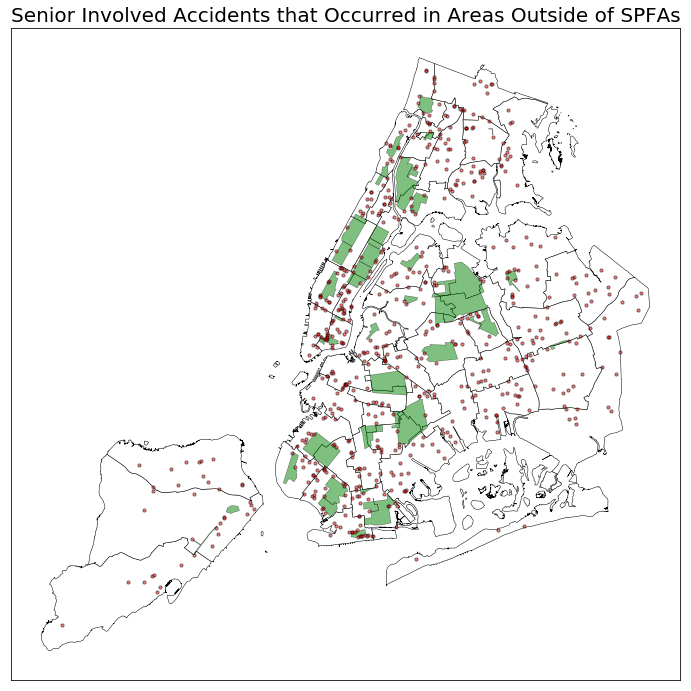

In [61]:
# Plot of accidents not in SPFAs
f, ax = plt.subplots(figsize=(12,12))
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
# NYC PUMAs
pumashp.plot(alpha=1,linewidth=0.5,ax=ax,color='w',edgecolor='black')
# SPFAs plotted in green
spfa.plot(alpha=.5,linewidth=0.5,ax=ax,color='green',edgecolor='black')
# Pedestrian accidents plotted in red dots
spfa_senior[(spfa_senior['acc_post_spfa']==0) & (spfa_senior['in_spfa']==0)].plot(alpha=.5, \
                                                                                    ax=ax, facecolor="r", edgecolor="k", markersize=10)
plt.title("Senior Involved Accidents that Occurred in Areas Outside of SPFAs", fontsize=20)
plt.show()